In [99]:
import pandas as pd
import requests
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import kendalltau
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import FunctionTransformer
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import statsmodels.api as sm
from xgboost import XGBRegressor

In [2]:
def fetch_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        data = pd.read_csv(StringIO(response.text))
        return data
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        return None

In [3]:
# URL набору даних
link = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv"

In [4]:
# Виклик функції для завантаження даних
data = fetch_data(link)

In [5]:
# Перегляд колонок у наборі даних
if data is not None:
    print(data.columns)
else:
    print("Дані не завантажено")

Index(['Unnamed: 0', 'item_id', 'name', 'category', 'price', 'old_price',
       'sellable_online', 'link', 'other_colors', 'short_description',
       'designer', 'depth', 'height', 'width'],
      dtype='object')


In [6]:
# Перевірка перших рядків завантажених даних
if data is not None:
    print(data.head().to_markdown(index=False))
else:
    print("Дані не завантажено")

|   Unnamed: 0 |   item_id | name                  | category      |   price | old_price    | sellable_online   | link                                                                                               | other_colors   | short_description                               | designer             |   depth |   height |   width |
|-------------:|----------:|:----------------------|:--------------|--------:|:-------------|:------------------|:---------------------------------------------------------------------------------------------------|:---------------|:------------------------------------------------|:---------------------|--------:|---------:|--------:|
|            0 |  90420332 | FREKVENS              | Bar furniture |     265 | No old price | True              | https://www.ikea.com/sa/en/p/frekvens-bar-table-in-outdoor-black-90420332/                         | No             | Bar table, in/outdoor,          51x51 cm        | Nicholai Wiig Hansen |     nan |       99 |   

In [7]:
# Частина перша: очистка даних.
if data is not None:
    # Перевірка на повні дублікати
    full_duplicates = data.duplicated().sum()
    print(f"Повні дублікати: {full_duplicates}")
    
    # Видалення повних дублікатів
    data = data.drop_duplicates()
    
    # Перевірка на сутнісні дублікати (наприклад, item_id)
    data['item_id'] = data['item_id'].astype(str)  # Перетворення item_id на строку
    subset_duplicates = data.duplicated(subset=['item_id']).sum()
    print(f"Сутнісні дублікати по item_id: {subset_duplicates}")
    
    # Видалення сутнісних дублікатів
    data = data.drop_duplicates(subset=['item_id'], keep='first')

Повні дублікати: 0
Сутнісні дублікати по item_id: 732


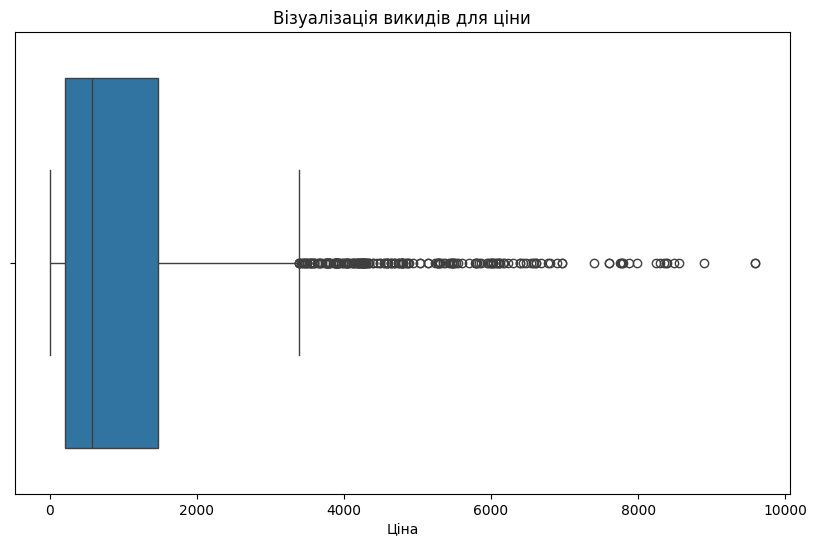

Кількість викидів: 219


In [8]:
# Аналіз та обробка викидів (outliers)
if data is not None:
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Візуалізація викидів для ціни
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data['price'])
    plt.title('Візуалізація викидів для ціни')
    plt.xlabel('Ціна')
    plt.show()

    # Видалення викидів на основі меж квартилів
    Q1 = data['price'].quantile(0.25)
    Q3 = data['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Залишаємо всі значення для уникнення перенавчання
    # Виконуємо аналіз, але не видаляємо викиди
    outliers = data[(data['price'] < lower_bound) | (data['price'] > upper_bound)]
    print(f"Кількість викидів: {outliers.shape[0]}")

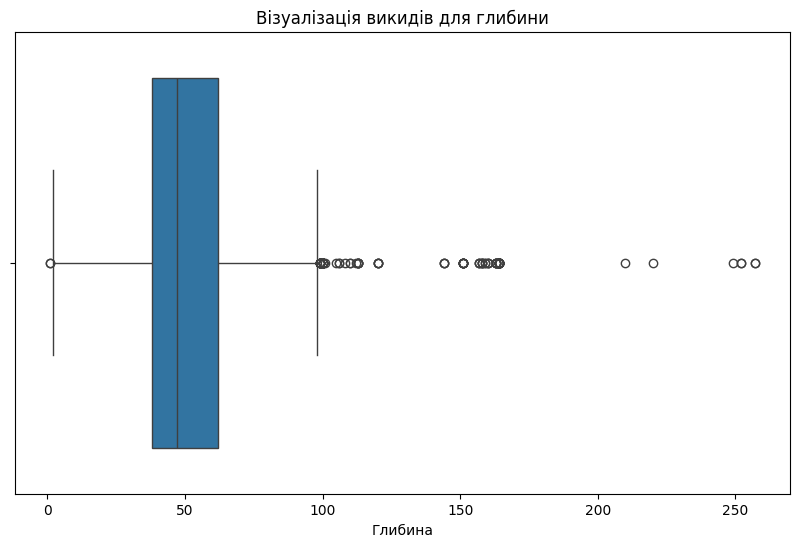

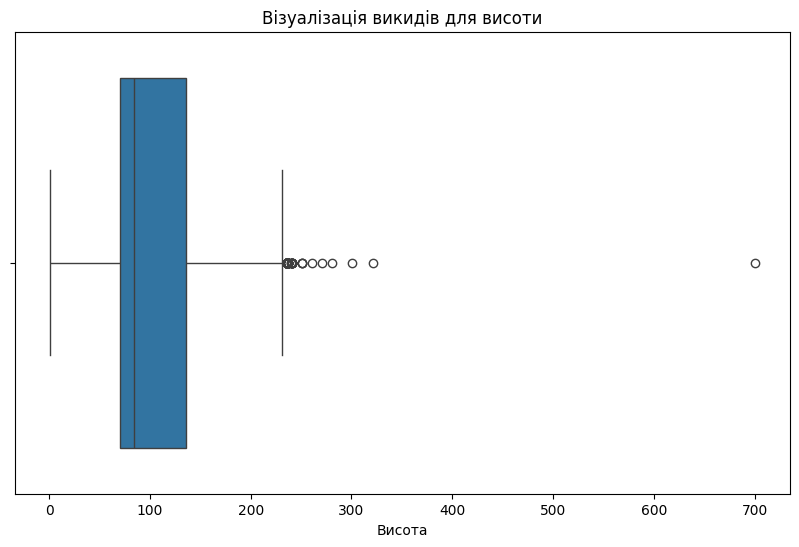

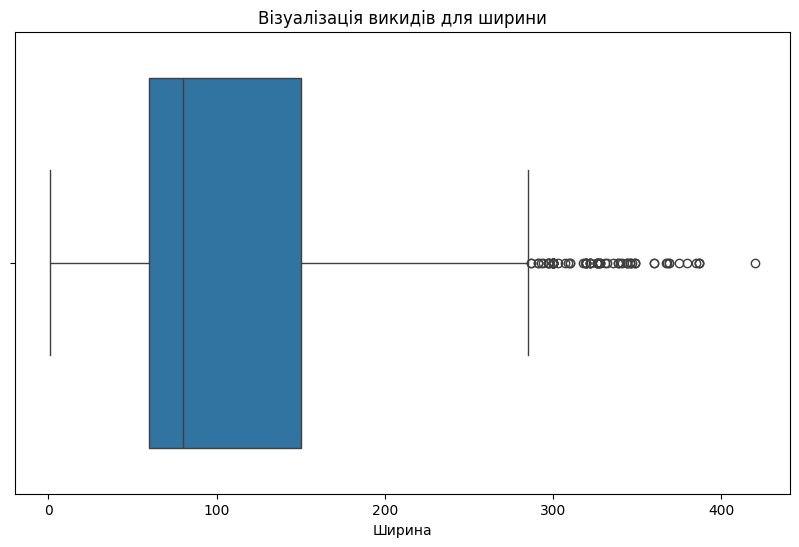

Викиди по глибині: 0
Викиди по висоті: 0
Викиди по ширині: 0


In [9]:
if data is not None:
    # Викиди для глибини (depth)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data['depth'])
    plt.title('Візуалізація викидів для глибини')
    plt.xlabel('Глибина')
    plt.show()
    
    # Викиди для висоти (height)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data['height'])
    plt.title('Візуалізація викидів для висоти')
    plt.xlabel('Висота')
    plt.show()
    
    # Викиди для ширини (width)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data['width'])
    plt.title('Візуалізація викидів для ширини')
    plt.xlabel('Ширина')
    plt.show()

    # Аналіз, але не видаляємо викиди для уникнення перенавчання
    depth_outliers = data[(data['depth'] < Q1 - 1.5 * IQR) | (data['depth'] > Q3 + 1.5 * IQR)]
    height_outliers = data[(data['height'] < Q1 - 1.5 * IQR) | (data['height'] > Q3 + 1.5 * IQR)]
    width_outliers = data[(data['width'] < Q1 - 1.5 * IQR) | (data['width'] > Q3 + 1.5 * IQR)]
    print(f"Викиди по глибині: {depth_outliers.shape[0]}")
    print(f"Викиди по висоті: {height_outliers.shape[0]}")
    print(f"Викиди по ширині: {width_outliers.shape[0]}")

In [10]:
# Аналіз даних у конкретних колонках
if data is not None:
    # Перевірка колонок на пропущені значення
    missing_values = data.isnull().sum()
    print(missing_values.to_markdown())
    
    # Заповнення пропущених значень (наприклад, для 'designer')
    data.loc[:, 'designer'] = data['designer'].fillna('Unknown')
    
    # Перетворення категоріальних змінних
    if 'category' in data.columns:
        data = pd.get_dummies(data, columns=['category'], drop_first=True)
    
    # Видалення колонок, які деформують модель даних (за необхідності)
    data = data.drop(['link', 'other_colors', 'short_description'], axis=1, errors='ignore')

|                   |    0 |
|:------------------|-----:|
| Unnamed: 0        |    0 |
| item_id           |    0 |
| name              |    0 |
| category          |    0 |
| price             |    0 |
| old_price         |    0 |
| sellable_online   |    0 |
| link              |    0 |
| other_colors      |    0 |
| short_description |    0 |
| designer          |    0 |
| depth             | 1118 |
| height            |  726 |
| width             |  442 |


In [11]:
# Проведемо очистку по старим цінам:
if data is not None:
    import numpy as np

    def clean_column(column):
        cleaned_column = []
        for item in column:
            if isinstance(item, str):
                if item == 'No old price':
                    cleaned_item = np.nan
                else:
                    cleaned_item = (
                        item.replace(',', '.')
                            .replace('SR', '')
                            .replace('/', '.')
                            .replace('pack', '')
                            .strip()
                    )
            else:
                cleaned_item = item
            cleaned_column.append(cleaned_item)
        return cleaned_column

    data['old_price'] = clean_column(data['old_price'])

    data['old_price'] = clean_column(data['old_price'])

In [12]:
# Проведемо очистку по дизайнерам:
if data is not None:
    def cleanDesigners(value, removeIKEA=False, emptyValue=np.nan):
        if not isinstance(value, str):
            return value
        if len(value) > 0 and value[0].isdigit():
            return emptyValue
        designers = value.split("/")
        if removeIKEA:
            try:
                designers.remove("IKEA of Sweden")
            except:
                pass
        if len(designers) > 0:
            return '/'.join(sorted(designers))
        else:
            return emptyValue

    data.loc[:, 'designer'] = data['designer'].apply(cleanDesigners)

In [13]:
# Очистка по опису:
if data is not None and 'short_description' in data.columns:
    data['short_description'] = data['short_description'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()

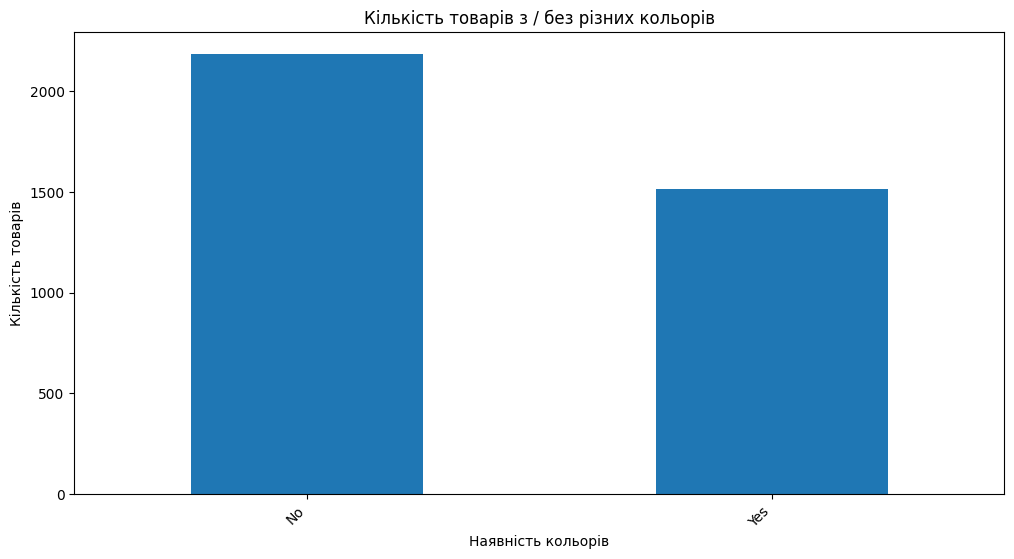

In [44]:
# Частина друга: описова статистика.

# 1. Кількість товарів з / без різних кольорів

# Візуалізація кількості товарів з / без різних кольорів
color_counts = data['other_colors'].value_counts()
plt.figure(figsize=(12, 6))
color_counts.plot(kind='bar')
plt.title('Кількість товарів з / без різних кольорів')
plt.xlabel('Наявність кольорів')
plt.ylabel('Кількість товарів')
plt.xticks(rotation=45, ha='right')
plt.show()

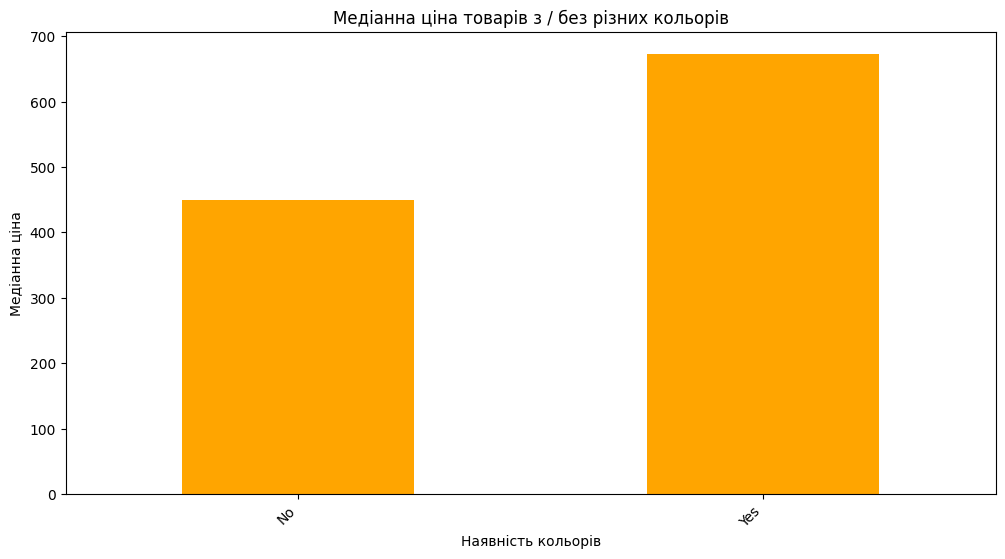

In [45]:
# 2. Медіанна ціна товарів з / без різних кольорів

# Візуалізація медіанної ціни товарів з / без різних кольорів
median_price_by_color = data.groupby('other_colors')['price'].median()
plt.figure(figsize=(12, 6))
median_price_by_color.plot(kind='bar', color='orange')
plt.title('Медіанна ціна товарів з / без різних кольорів')
plt.xlabel('Наявність кольорів')
plt.ylabel('Медіанна ціна')
plt.xticks(rotation=45, ha='right')
plt.show()

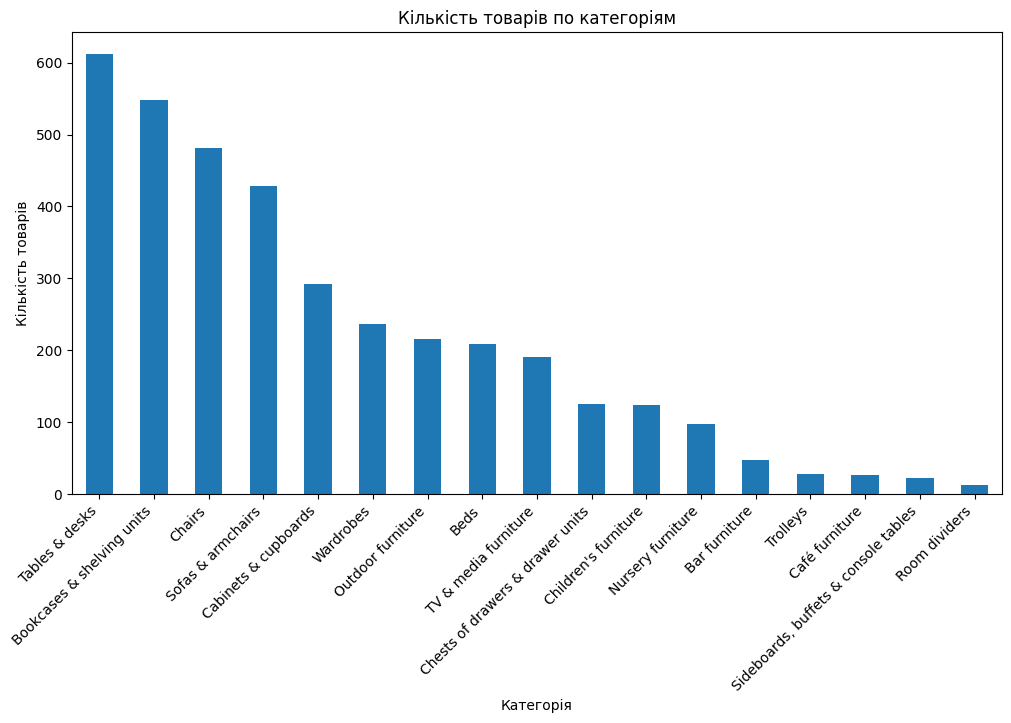

In [46]:
# 3. Кількість товарів по категоріям

# Візуалізація кількості товарів по категоріям
category_counts = data['category'].value_counts()
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar')
plt.title('Кількість товарів по категоріям')
plt.xlabel('Категорія')
plt.ylabel('Кількість товарів')
plt.xticks(rotation=45, ha='right')
plt.show()

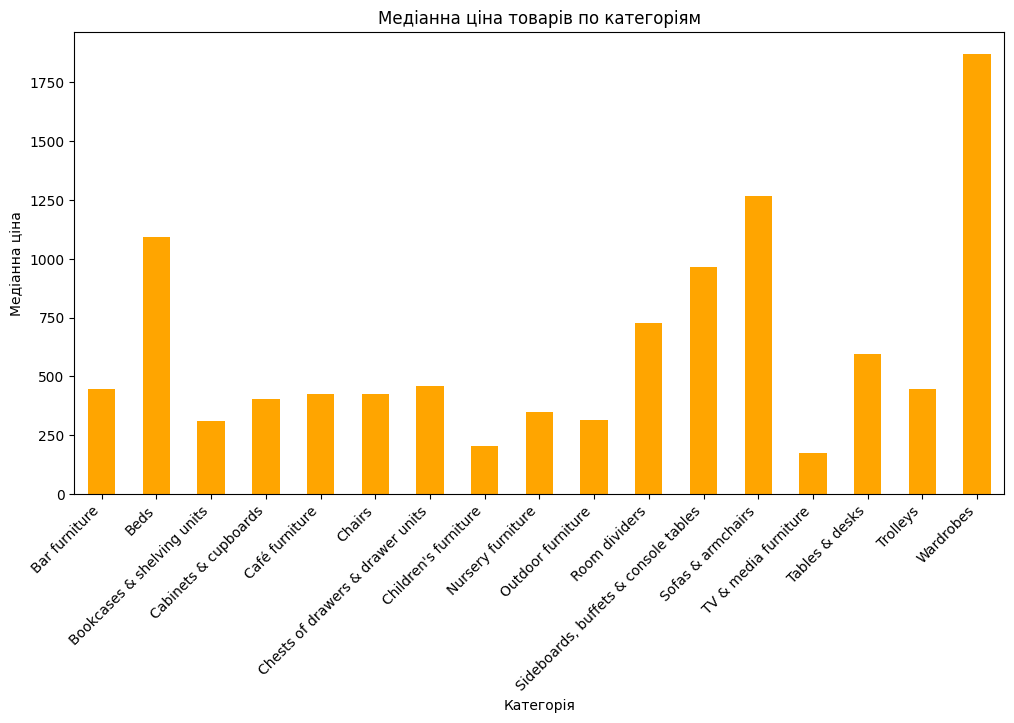

In [47]:
# 4. Медіанна ціна товарів по категоріям

# Візуалізація медіанної ціни товарів по категоріям
median_price_by_category = data.groupby('category')['price'].median()
plt.figure(figsize=(12, 6))
median_price_by_category.plot(kind='bar', color='orange')
plt.title('Медіанна ціна товарів по категоріям')
plt.xlabel('Категорія')
plt.ylabel('Медіанна ціна')
plt.xticks(rotation=45, ha='right')
plt.show()

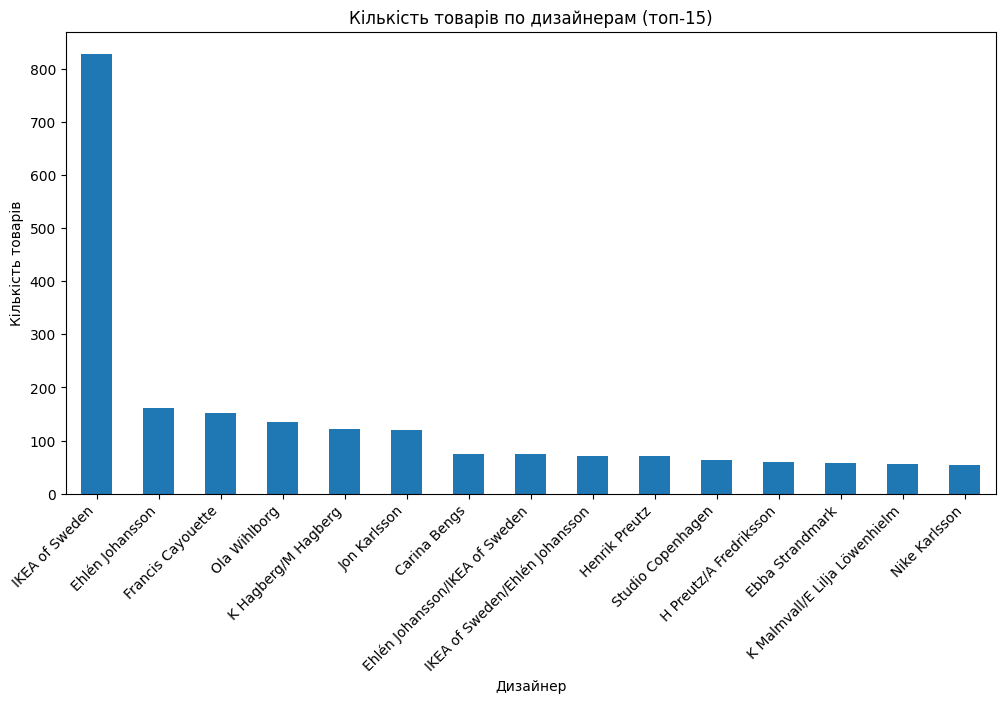

In [48]:
# 5. Кількість товарів по дизайнерам (топ-15)

# Візуалізація кількості товарів по дизайнерам (топ-15)
top_15_designers = data['designer'].value_counts().head(15)
plt.figure(figsize=(12, 6))
top_15_designers.plot(kind='bar')
plt.title('Кількість товарів по дизайнерам (топ-15)')
plt.xlabel('Дизайнер')
plt.ylabel('Кількість товарів')
plt.xticks(rotation=45, ha='right')
plt.show()

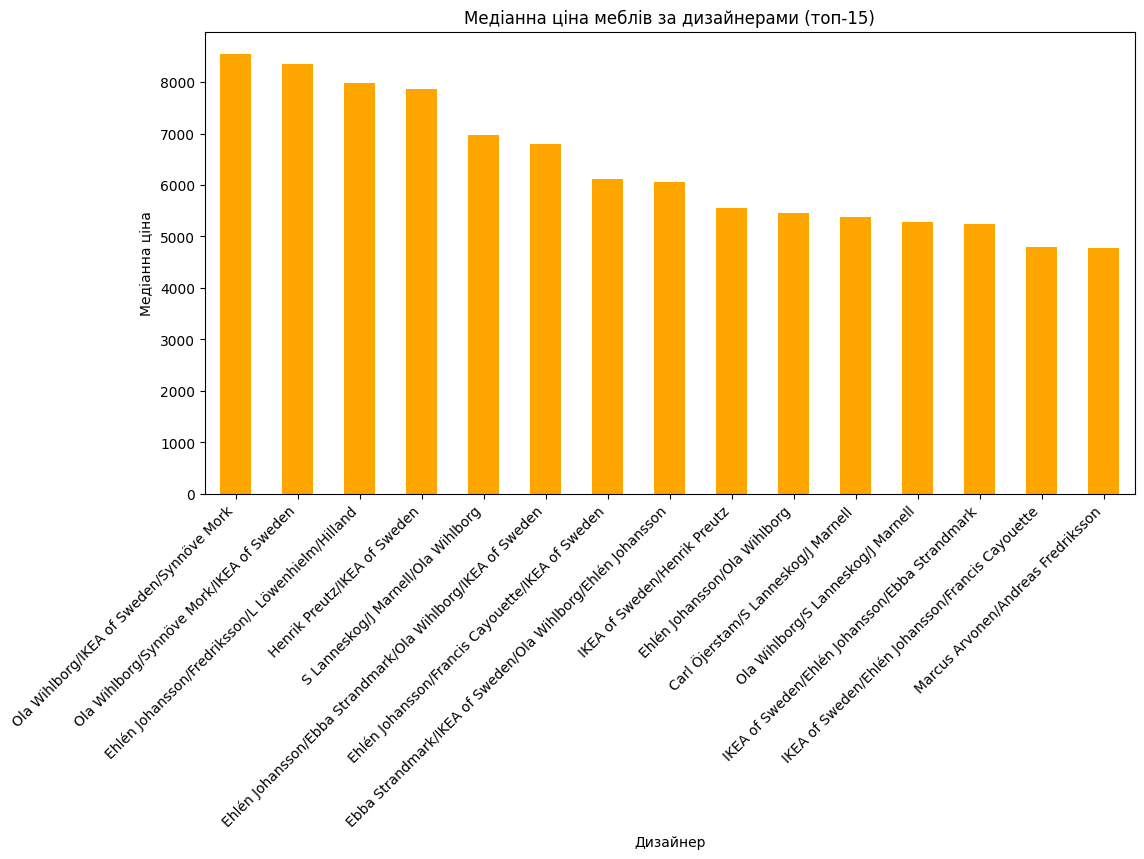

In [49]:
# 6. Медіанна ціна меблів за дизайнерами (топ-15)

# Візуалізація медіанної ціни меблів за дизайнерами (топ-15)
median_price_by_designer = data.groupby('designer')['price'].median().nlargest(15)
plt.figure(figsize=(12, 6))
median_price_by_designer.plot(kind='bar', color='orange')
plt.title('Медіанна ціна меблів за дизайнерами (топ-15)')
plt.xlabel('Дизайнер')
plt.ylabel('Медіанна ціна')
plt.xticks(rotation=45, ha='right')
plt.show()

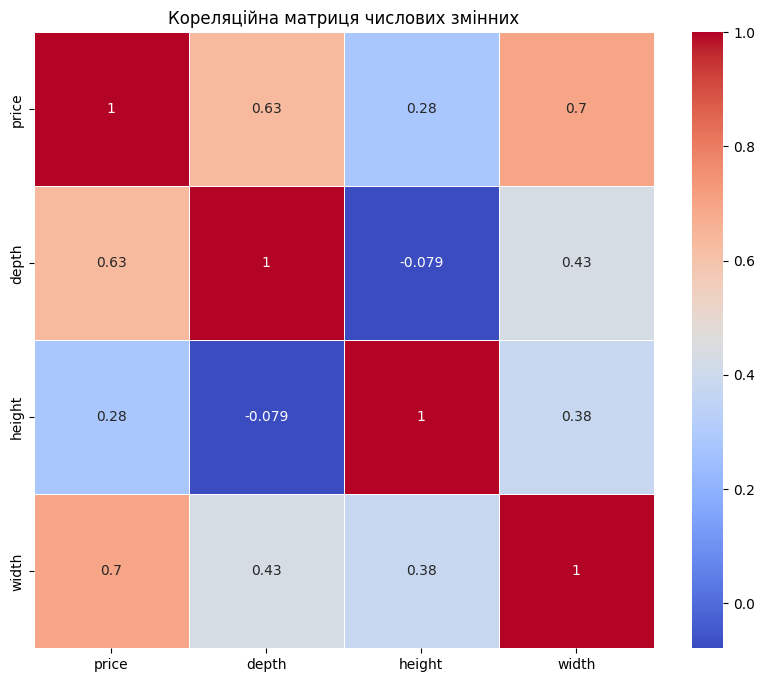

In [50]:
# 7. Кореляційна матриця числових змінних (ціна та габарити)

import seaborn as sns

# Кореляційна матриця
correlation_matrix = data[['price', 'depth', 'height', 'width']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Кореляційна матриця числових змінних')
plt.show()

In [57]:
# Частина третя

# Гіпотеза 1: Вплив категорії товарів на кінцеву ціну меблів
# Нульова гіпотеза: Категорія товарів не впливає на кінцеву ціну меблів.
# Альтернативна гіпотеза: Категорія товарів впливає на кінцеву ціну меблів.

In [65]:
# Тест 1: Коефіцієнт кореляції Пірсона

# Перетворимо категорії на числові значення
data['category_numeric'] = pd.factorize(data['category'])[0]

# Коефіцієнт кореляції Пірсона
pearson_corr = stats.pearsonr(data['category_numeric'], data['price'])
print(f"Коефіцієнт кореляції Пірсона: {pearson_corr[0]}, P-значення: {pearson_corr[1]}")

Коефіцієнт кореляції Пірсона: 0.19581085115736208, P-значення: 3.018232396228557e-33


In [66]:
# Тест 2: Регресійний аналіз

# Конвертуємо цільовий стовпець у числовий тип
data['price'] = pd.to_numeric(data['price'], errors='coerce')

# Підготовка даних для регресійного аналізу
X = pd.get_dummies(data['category'], drop_first=True)
X = X.astype(float)  # Конвертація даних у числовий тип
y = data['price']
X = sm.add_constant(X)  # Додавання константи

# Регресійний аналіз
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     44.18
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          1.70e-127
Time:                        21:38:02   Log-Likelihood:                -31609.
No. Observations:                3694   AIC:                         6.325e+04
Df Residuals:                    3677   BIC:                         6.336e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [67]:
# Тест 3: Критерій Краскела-Воліса

# Розподіл даних на групи за медіаною габаритів
median_depth = data['depth'].median()
median_height = data['height'].median()
median_width = data['width'].median()

grouped_prices_depth = [data[data['depth'] <= median_depth]['price'].dropna(),
                        data[data['depth'] > median_depth]['price'].dropna()]
grouped_prices_height = [data[data['height'] <= median_height]['price'].dropna(),
                         data[data['height'] > median_height]['price'].dropna()]
grouped_prices_width = [data[data['width'] <= median_width]['price'].dropna(),
                        data[data['width'] > median_width]['price'].dropna()]

# Критерій Краскела-Воліса
kruskal_depth = kruskal(*grouped_prices_depth)
kruskal_height = kruskal(*grouped_prices_height)
kruskal_width = kruskal(*grouped_prices_width)

print(f"Краскела-Воліса (глибина): H-статистика: {kruskal_depth.statistic}, P-значення: {kruskal_depth.pvalue}")
print(f"Краскела-Воліса (висота): H-статистика: {kruskal_height.statistic}, P-значення: {kruskal_height.pvalue}")
print(f"Краскела-Воліса (ширина): H-статистика: {kruskal_width.statistic}, P-значення: {kruskal_width.pvalue}")

Краскела-Воліса (глибина): H-статистика: 245.5042366363132, P-значення: 2.4807991857986637e-55
Краскела-Воліса (висота): H-статистика: 385.4055804973406, P-значення: 8.281385028381281e-86
Краскела-Воліса (ширина): H-статистика: 1239.8875258192465, P-значення: 1.308410523097215e-271


In [ ]:
# Гіпотеза 2: Вплив габаритів меблів на їх кінцеву ціну
# Нульова гіпотеза: Габарити меблів не впливають на кінцеву ціну.
# Альтернативна гіпотеза: Габарити меблів впливають на кінцеву ціну.

In [72]:
# Тест 1: Кореляційний аналіз за Спірменом

# Кореляція Спірмена для габаритів і ціни
spearman_corr_depth = stats.spearmanr(data['depth'], data['price'])
spearman_corr_height = stats.spearmanr(data['height'], data['price'])
spearman_corr_width = stats.spearmanr(data['width'], data['price'])

print(f"Кореляція Спірмена (глибина): {spearman_corr_depth.correlation}, P-значення: {spearman_corr_depth.pvalue}")
print(f"Кореляція Спірмена (висота): {spearman_corr_height.correlation}, P-значення: {spearman_corr_height.pvalue}")
print(f"Кореляція Спірмена (ширина): {spearman_corr_width.correlation}, P-значення: {spearman_corr_width.pvalue}")

Кореляція Спірмена (глибина): 0.3379891467366249, P-значення: 2.1724239692098086e-99
Кореляція Спірмена (висота): 0.38298565520065264, P-значення: 2.3382807161830092e-129
Кореляція Спірмена (ширина): 0.6617229385654817, P-значення: 0.0


In [73]:
# Тест 2: Лінійна регресія

# Підготовка даних
X = data[['depth', 'height', 'width']]
y = data['price']

# Лінійна регресія
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
y_pred = linear_regressor.predict(X)

# Виведення коефіцієнтів регресії
coefficients = linear_regressor.coef_
intercept = linear_regressor.intercept_
print(f"Коефіцієнти регресії: {coefficients}")
print(f"Інтерцепт: {intercept}")

Коефіцієнти регресії: [15.71397519  1.58807738 11.05778869]
Інтерцепт: -995.9931421365216


In [75]:
# Тест 3: Порівняння медіанних значень за допомогою тесту Манна-Уітні

# Розподіл даних на групи за медіаною габаритів
median_depth = data['depth'].median()
median_height = data['height'].median()
median_width = data['width'].median()

grouped_prices_depth = [data[data['depth'] <= median_depth]['price'].dropna(),
                        data[data['depth'] > median_depth]['price'].dropna()]
grouped_prices_height = [data[data['height'] <= median_height]['price'].dropna(),
                         data[data['height'] > median_height]['price'].dropna()]
grouped_prices_width = [data[data['width'] <= median_width]['price'].dropna(),
                        data[data['width'] > median_width]['price'].dropna()]

# Тест Манна-Уітні
mannwhitney_depth = stats.mannwhitneyu(grouped_prices_depth[0], grouped_prices_depth[1])
mannwhitney_height = stats.mannwhitneyu(grouped_prices_height[0], grouped_prices_height[1])
mannwhitney_width = stats.mannwhitneyu(grouped_prices_width[0], grouped_prices_width[1])

print(f"Манн-Уітні (глибина): U-статистика: {mannwhitney_depth.statistic}, P-значення: {mannwhitney_depth.pvalue}")
print(f"Манн-Уітні (висота): U-статистика: {mannwhitney_height.statistic}, P-значення: {mannwhitney_height.pvalue}")
print(f"Манн-Уітні (ширина): U-статистика: {mannwhitney_width.statistic}, P-значення: {mannwhitney_width.pvalue}")

Манн-Уітні (глибина): U-статистика: 950539.5, P-значення: 2.443735832148264e-50
Манн-Уітні (висота): U-статистика: 890468.5, P-значення: 4.1792834680182716e-104
Манн-Уітні (ширина): U-статистика: 519778.0, P-значення: 4.930059888919519e-269


In [85]:
# Частина четверта: машинне навчання

# Числові та категоріальні стовпці
numerical_features = ['depth', 'height', 'width']
categorical_features = ['name', 'link', 'short_description', 'sellable_online', 'category', 'designer', 'other_colors']

# Трансформери для числових даних
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Трансформери для категоріальних даних
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Об'єднання трансформерів у препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [86]:
# Визначення предикторів (X) та цільової змінної (y)
X = data.drop('price', axis=1)
y = data['price']

# Розподіл на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
# Модель 1: Linear Regression

# Побудова моделі лінійної регресії
model_lr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())])

# Тренування моделі
model_lr.fit(X_train, y_train)

# Прогнозування
y_pred_lr = model_lr.predict(X_test)

# Оцінка моделі
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MAE: {mae_lr}, RMSE: {rmse_lr}, R2: {r2_lr}")

Linear Regression - MAE: 267.4353582297262, RMSE: 535.9333055536932, R2: 0.850984930962329


In [93]:
# Модель 2: Decision Tree Regressor

# Побудова моделі дерева рішень
model_dtr = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', DecisionTreeRegressor(random_state=42))])

# Тренування моделі
model_dtr.fit(X_train, y_train)

# Прогнозування
y_pred_dtr = model_dtr.predict(X_test)

# Оцінка моделі
mae_dtr = mean_absolute_error(y_test, y_pred_dtr)
rmse_dtr = np.sqrt(mean_squared_error(y_test, y_pred_dtr))
r2_dtr = r2_score(y_test, y_pred_dtr)

print(f"Decision Tree Regressor - MAE: {mae_dtr}, RMSE: {rmse_dtr}, R2: {r2_dtr}")

Decision Tree Regressor - MAE: 282.8036535859269, RMSE: 701.7817908839172, R2: 0.7444870683315568


In [92]:
# Модель 3: Random Forest Regressor

# Побудова моделі случайного лісу
model_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', RandomForestRegressor(random_state=42))])

# Тренування моделі
model_rfr.fit(X_train, y_train)

# Прогнозування
y_pred_rfr = model_rfr.predict(X_test)

# Оцінка моделі
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
r2_rfr = r2_score(y_test, y_pred_rfr)

print(f"Random Forest Regressor - MAE: {mae_rfr}, RMSE: {rmse_rfr}, R2: {r2_rfr}")

Random Forest Regressor - MAE: 286.2872895805142, RMSE: 621.1406667509151, R2: 0.7998347782798894


In [91]:
# Модель 4: Gradient Boosting Regressor

# Побудова моделі градієнтного бустингу
model_gbr = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', GradientBoostingRegressor(random_state=42))])

# Тренування моделі
model_gbr.fit(X_train, y_train)

# Прогнозування
y_pred_gbr = model_gbr.predict(X_test)

# Оцінка моделі
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting Regressor - MAE: {mae_gbr}, RMSE: {rmse_gbr}, R2: {r2_gbr}")

Gradient Boosting Regressor - MAE: 441.29106675940847, RMSE: 698.4530417594705, R2: 0.7469052595318137


In [95]:
# Модель 5: KNeighbors Regressor

# Побудова моделі K-найближчих сусідів
model_knr = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', KNeighborsRegressor(n_neighbors=8))])

# Тренування моделі
model_knr.fit(X_train, y_train)

# Прогнозування
y_pred_knr = model_knr.predict(X_test)

# Оцінка моделі
mae_knr = mean_absolute_error(y_test, y_pred_knr)
rmse_knr = np.sqrt(mean_squared_error(y_test, y_pred_knr))
r2_knr = r2_score(y_test, y_pred_knr)

print(f"KNeighbors Regressor - MAE: {mae_knr}, RMSE: {rmse_knr}, R2: {r2_knr}")

KNeighbors Regressor - MAE: 342.97719891745606, RMSE: 613.9298203992236, R2: 0.8044552538673124


XGBoost Regressor - MAE: 316.24901297134375, RMSE: 570.7322433422245, R2: 0.8310051339278541


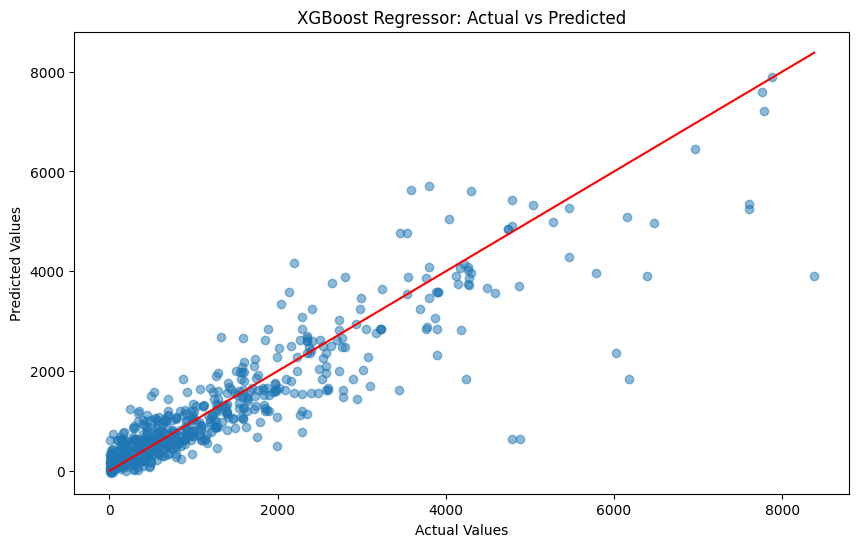

                         Model         MAE        RMSE        R2
0            Linear Regression  267.435358  535.933306  0.850985
1      Decision Tree Regressor  282.803654  701.781791  0.744487
2      Random Forest Regressor  286.287290  621.140667  0.799835
3  Gradient Boosting Regressor  441.291067  698.453042  0.746905
4         KNeighbors Regressor  342.977199  613.929820  0.804455
5            XGBoost Regressor  316.249013  570.732243  0.831005


In [101]:
# Модель 6: XGBoost

# Препроцесинг для інших моделей з використанням Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['depth', 'height', 'width']),
        ('cat', categorical_transformer, ['name', 'link', 'short_description', 'sellable_online', 'category', 'designer', 'other_colors'])
    ])

# Розподіл на тренувальну та тестову вибірки
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Препроцесинг тренувальних та тестових даних
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Побудова та тренування моделі XGBoost окремо
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
model_xgb.fit(X_train_transformed, y_train)

# Прогнозування
y_pred_xgb = model_xgb.predict(X_test_transformed)

# Оцінка моделі
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Regressor - MAE: {mae_xgb}, RMSE: {rmse_xgb}, R2: {r2_xgb}")

# Візуалізація справжніх та прогнозованих значень для XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Regressor: Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

# Порівняння результатів моделей (включаючи вже розглянуті моделі)
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'KNeighbors Regressor', 'XGBoost Regressor'],
    'MAE': [mae_lr, mae_dtr, mae_rfr, mae_gbr, mae_knr, mae_xgb],
    'RMSE': [rmse_lr, rmse_dtr, rmse_rfr, rmse_gbr, rmse_knr, rmse_xgb],
    'R2': [r2_lr, r2_dtr, r2_rfr, r2_gbr, r2_knr, r2_xgb]
})

print(results)

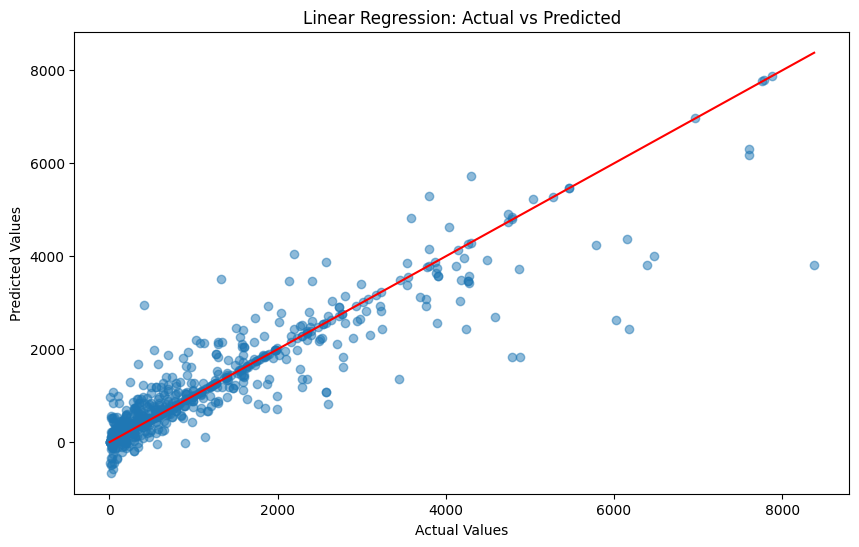

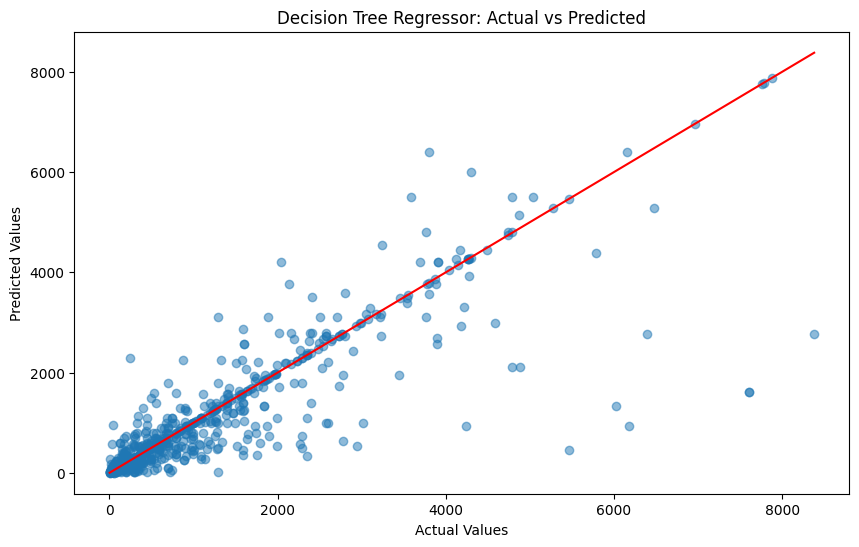

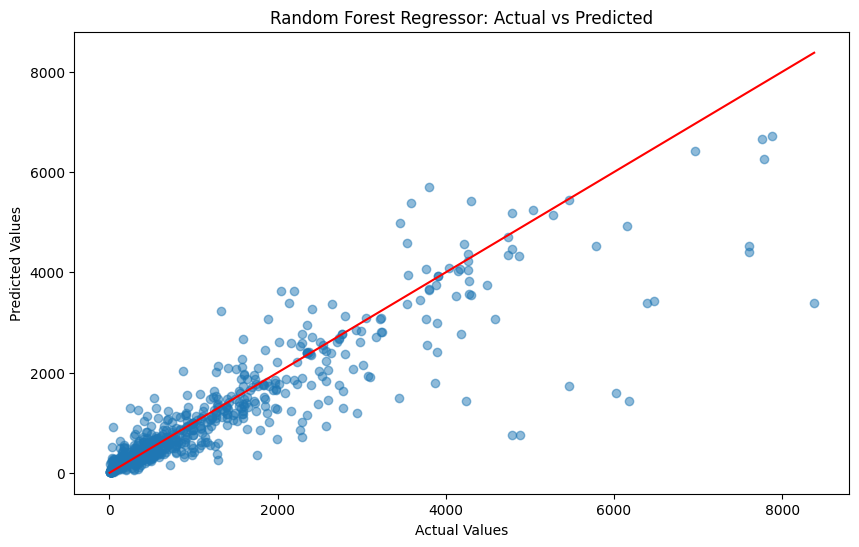

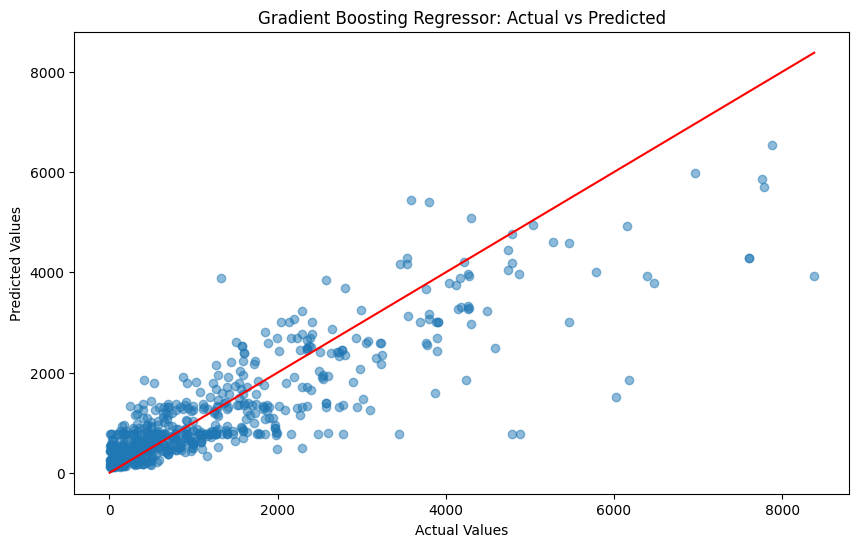

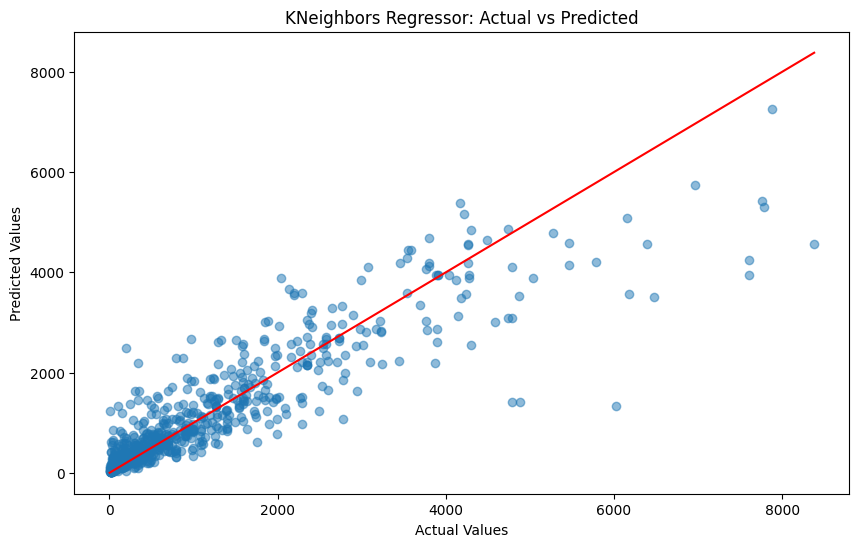

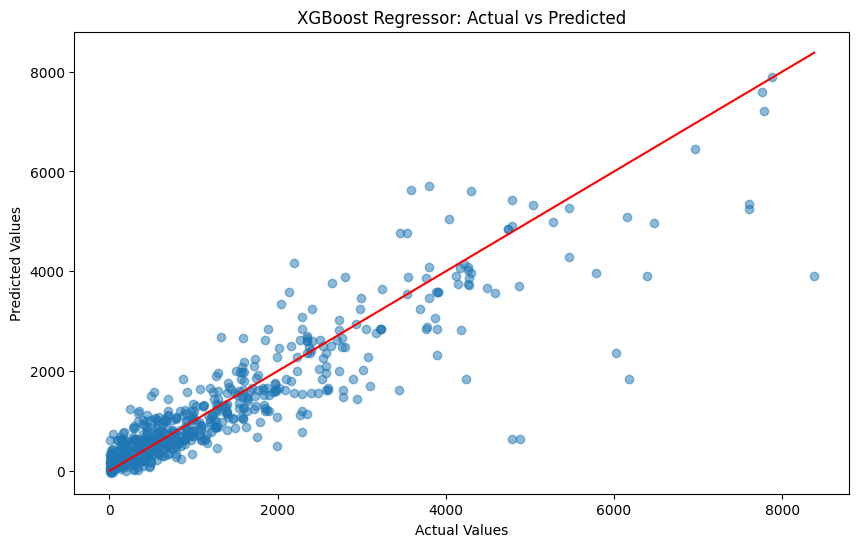

In [104]:
# Візуалізація справжніх та прогнозованих значень для лінійної регресії
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

# Візуалізація справжніх та прогнозованих значень для дерева рішень
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_dtr, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree Regressor: Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

# Візуалізація справжніх та прогнозованих значень для случайного лісу
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rfr, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regressor: Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

# Візуалізація справжніх та прогнозованих значень для градієнтного бустингу
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gbr, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Gradient Boosting Regressor: Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

# Візуалізація справжніх та прогнозованих значень для K-найближчих сусідів
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_knr, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('KNeighbors Regressor: Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

# Візуалізація справжніх та прогнозованих значень для XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Regressor: Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

In [105]:
# Параметри для Grid Search
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Побудова моделі случайного лісу з Grid Search
model_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', RandomForestRegressor(random_state=42))])

# Виконання Grid Search
grid_search = GridSearchCV(estimator=model_rfr, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)

# Найкращі параметри та оцінка
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best R2 score from Grid Search: {best_score}")

# Прогнозування з використанням найкращої моделі
best_model_rfr = grid_search.best_estimator_
y_pred_best_rfr = best_model_rfr.predict(X_test)

# Оцінка найкращої моделі
mae_best_rfr = mean_absolute_error(y_test, y_pred_best_rfr)
rmse_best_rfr = np.sqrt(mean_squared_error(y_test, y_pred_best_rfr))
r2_best_rfr = r2_score(y_test, y_pred_best_rfr)

print(f"Random Forest Regressor (Best) - MAE: {mae_best_rfr}, RMSE: {rmse_best_rfr}, R2: {r2_best_rfr}")

Best parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best R2 score from Grid Search: 0.825091556100934
Random Forest Regressor (Best) - MAE: 296.2675977739246, RMSE: 622.9585392073061, R2: 0.7986614295258562


In [107]:
# Оцінка моделі з використанням крос-валідації
cross_val_scores = cross_val_score(best_model_rfr, X_train, y_train, cv=5, scoring='r2')

# Виведення результатів крос-валідації
mean_score = cross_val_scores.mean()
std_score = cross_val_scores.std()

print(f"Cross-validation R2 scores: {cross_val_scores}")
print(f"Mean R2 score: {mean_score}")
print(f"Standard deviation of R2 scores: {std_score}")

Cross-validation R2 scores: [0.81388149 0.80352148 0.86426086 0.80103816 0.8427558 ]
Mean R2 score: 0.825091556100934
Standard deviation of R2 scores: 0.024559151099313416


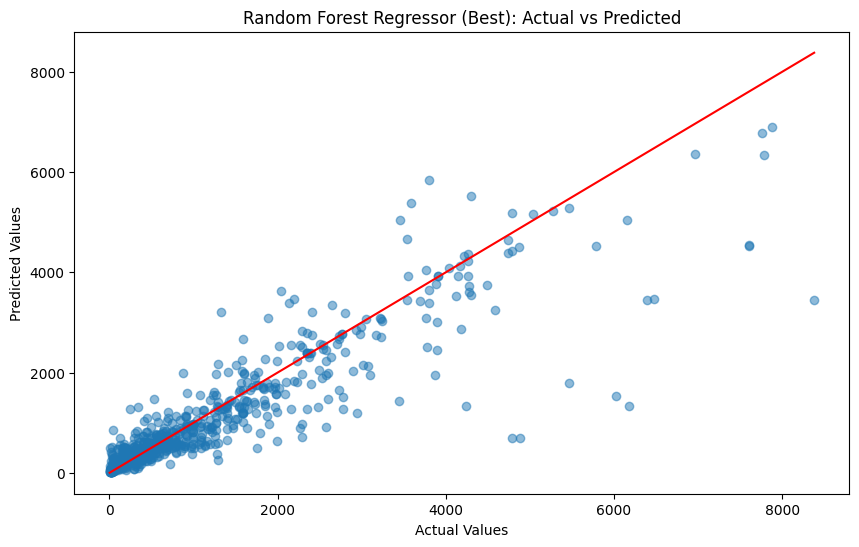

In [108]:
# Візуалізація справжніх та прогнозованих значень для найкращої моделі случайного лісу
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_rfr, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regressor (Best): Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

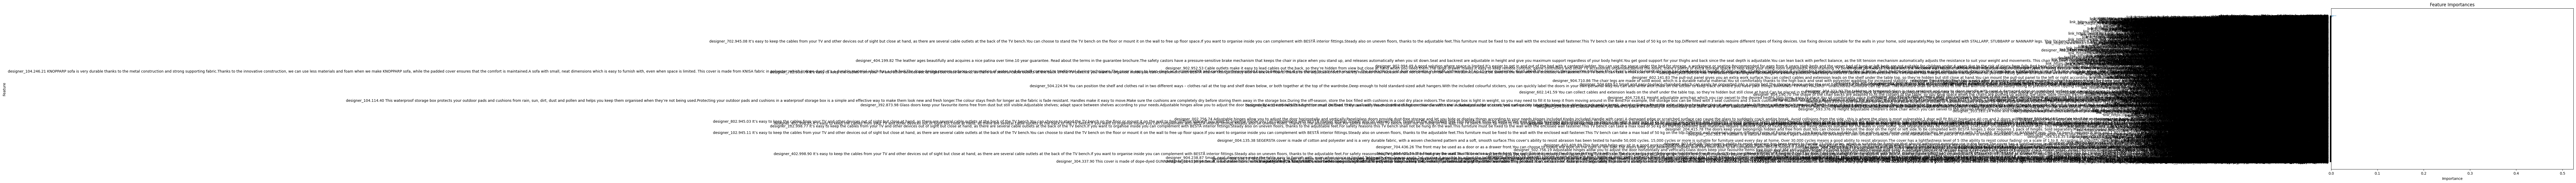

In [110]:
# Визначення важливості фічей
feature_importances = best_model_rfr.named_steps['model'].feature_importances_
feature_names = preprocessor.transformers_[0][2] + list(preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))

# Створення DataFrame для важливості фічей
features_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Візуалізація важливості фічей
plt.figure(figsize=(12, 8))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()